In [88]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import scipy.stats
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection

In [89]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [90]:
class ICAWrapper:
    NAME = 'ICA'
    def __init__(self, n_components) -> None:
        self.model = FastICA(n_components=n_components, max_iter=1000)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)

class PCAWrapper:
    NAME = 'PCA'
    def __init__(self, n_components) -> None:
        self.model = PCA(n_components=n_components)

    def fit(self, X):
        return self.model.fit(X)

    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

class RPWrapper:
    NAME = 'RP'
    def __init__(self, n_components) -> None:
        self.model = GaussianRandomProjection(n_components=n_components)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

    def get_reconstruction_error(self, X):
        X_star = self.model.fit_transform(X)
        X_reconstructed = self.model.inverse_transform(X_star)
        return np.mean(np.square(X - X_reconstructed))
    
class LLEWrapper:
    NAME = 'LLE'
    def __init__(self, n_components) -> None:
        self.model = LocallyLinearEmbedding(n_components=n_components, n_neighbors=10)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)
    
    def get_reconstruction_error(self):
        return self.model.reconstruction_error_

In [91]:
# DATASET_NAME = 'mnist'
DATASET_NAME = 'wine_quality'

METHOD = ICAWrapper
K_FOLDS = 3
SAVE = True

In [92]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

if DATASET_NAME == 'mnist':
    n = 5000
    X = X[:n]
    y = y[:n]

In [93]:
df_path = f'results/{DATASET_NAME}/{METHOD.NAME}_metrics.csv'
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
    df.set_index('num_components', inplace=True)
    df['num_components'] = df.index
else:
    df = pd.DataFrame()

In [94]:
n = X.shape[0] // K_FOLDS

if DATASET_NAME == 'mnist':
    range_ = [2,3,4]+list(range(5, 100, 5))
    print(range_)
elif DATASET_NAME == 'wine_quality':
    range_ = range(2, 12)

for components in tqdm(range_):
    print(components)
    training_time_list = []
    evaluation_time_list = []
    kurtosis_list = []
    reconstruction_error_list = []
    acc_list = []
    for i in range(K_FOLDS):
        X_train = np.concatenate([X[:i * n], X[(i + 1) * n:]])
        y_train = np.concatenate([y[:i * n], y[(i + 1) * n:]])
        X_test = X[i * n:(i + 1) * n]
        y_test = y[i * n:(i + 1) * n]

        model = METHOD(components)
        t0 = time.perf_counter()
        X_train_star = model.fit_transform(X_train)
        t1 = time.perf_counter()
        training_time_list.append(t1 - t0)

        t0 = time.perf_counter()
        X_test_star = model.transform(X_test) 
        t1 = time.perf_counter()
        evaluation_time_list.append(t1 - t0)

        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(model.transform(X_train), y_train)
        acc_knn = knn.score(model.transform(X_test), y_test)
        acc_list.append(acc_knn)

        if METHOD == ICAWrapper:
            # calculate kurtosis using X_test_star
            kurtosis = scipy.stats.kurtosis(X_test_star, axis=0)
            kurtosis_list.append(kurtosis)

        if METHOD == RPWrapper:
            error = model.get_reconstruction_error(X_test)
            reconstruction_error_list.append(error)

        if METHOD == LLEWrapper:
            error = model.get_reconstruction_error()
            reconstruction_error_list.append(error)

    df.loc[components, 'num_components'] = components
    df.loc[components, 'training_time_mean'] = np.mean(training_time_list)
    df.loc[components, 'training_time_std'] = np.std(training_time_list)
    df.loc[components, 'evaluation_time_mean'] = np.mean(evaluation_time_list)
    df.loc[components, 'evaluation_time_std'] = np.std(evaluation_time_list)
    df.loc[components, 'accuracy_mean'] = np.mean(acc_list)
    df.loc[components, 'accuracy_std'] = np.std(acc_list)
    if METHOD == RPWrapper or METHOD == LLEWrapper:
        df.loc[components, 'reconstruction_error_mean'] = np.mean(reconstruction_error_list)
        df.loc[components, 'reconstruction_error_std'] = np.std(reconstruction_error_list)
    if METHOD == ICAWrapper:
        df.loc[components, 'kurtosis_mean'] = np.mean(kurtosis_list)
        df.loc[components, 'kurtosis_std'] = np.std(kurtosis_list)

  0%|          | 0/10 [00:00<?, ?it/s]

2


 10%|█         | 1/10 [00:00<00:01,  4.54it/s]

3


 20%|██        | 2/10 [00:00<00:02,  4.00it/s]

4


/home/stevie/git/gatech/machine_learning/unsupervised_learning/venv/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 30%|███       | 3/10 [00:01<00:03,  1.79it/s]

5


 40%|████      | 4/10 [00:01<00:02,  2.20it/s]

6


 50%|█████     | 5/10 [00:02<00:02,  2.44it/s]

7


 60%|██████    | 6/10 [00:02<00:01,  2.59it/s]

8


 70%|███████   | 7/10 [00:02<00:01,  2.62it/s]

9


 80%|████████  | 8/10 [00:03<00:00,  2.65it/s]

10


 90%|█████████ | 9/10 [00:03<00:00,  2.19it/s]

11


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


In [95]:
if SAVE:
    os.makedirs(os.path.dirname(df_path), exist_ok=True)
    df.to_csv(df_path, index=False)

In [96]:
if DATASET_NAME == 'mnist':
    # components = 196
    components = 40
elif DATASET_NAME == 'wine_quality':
    components = 11

(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ -0.88350894,  67.62834327, 136.14019549, 204.65204771,
        273.16389992, 341.67575214, 410.18760436, 478.69945657,
        547.21130879, 615.72316101, 684.23501322]),
 <BarContainer object of 10 artists>)

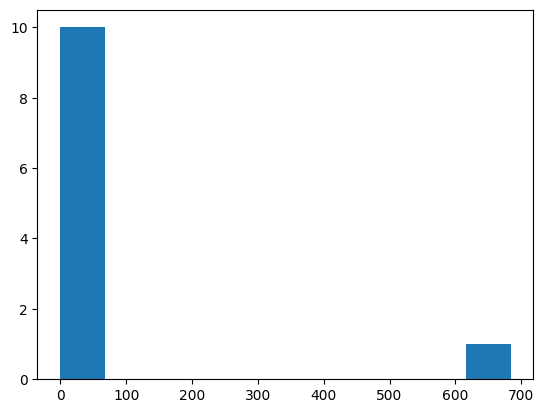

In [97]:
import matplotlib.pyplot as plt
plt.hist(kurtosis)

In [98]:
for i in range(K_FOLDS):
    X_train = np.concatenate([X[:i * n], X[(i + 1) * n:]])
    y_train = np.concatenate([y[:i * n], y[(i + 1) * n:]])
    X_test = X[i * n:(i + 1) * n]
    y_test = y[i * n:(i + 1) * n]
    model = FastICA(n_components=components, max_iter=1000)
    X_train_star = model.fit_transform(X_train)
    kurtosis = scipy.stats.kurtosis(X_train_star, axis=0)
    c = []
    scores = []
    for i in tqdm(range(0, components)):
        knn = KNeighborsClassifier(n_neighbors=3)
        thresh = np.sort(kurtosis)[::-1][i]
        mask = kurtosis <= thresh
        knn.fit(model.transform(X_train)[:, mask], y_train)
        acc_knn = knn.score(model.transform(X_test)[:, mask], y_test)
        c.append(np.sum(mask))
        scores.append(acc_knn)

100%|██████████| 11/11 [00:01<00:00, 10.75it/s]


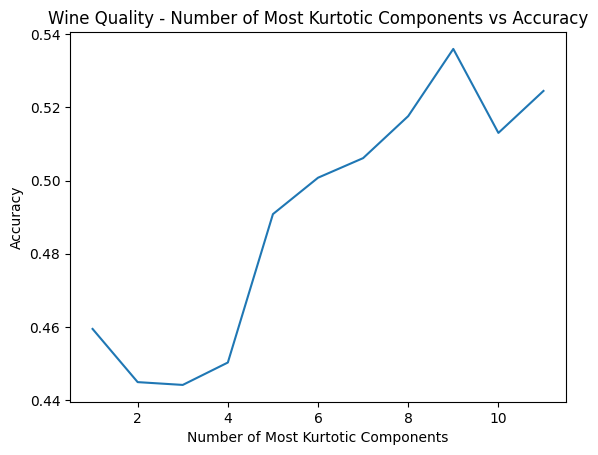

In [100]:
plt.title(f'{DATASET_STR} - Number of Most Kurtotic Components vs Accuracy')
plt.xlabel('Number of Most Kurtotic Components')
plt.ylabel('Accuracy')
plt.plot(c, scores)
plt.savefig(f'figures/{DATASET_NAME}_{METHOD.NAME}_kurtosis_vs_accuracy.png')